In [1]:
import os
import sys
import copy
import math
import json
import pysal
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.special import logsumexp
from shapely.geometry import shape
from scipy.optimize import minimize

#Direct input 
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 20,
          'legend.fontsize': 20,
          'legend.handlelength': 2,
          'font.family' : 'sans-serif',
          'font.sans-serif':['Helvetica'],
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

cwd = os.getcwd()
rd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0])
if not rd.endswith('stochastic-travel-demand-modelling'):
    rd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0],'stochastic-travel-demand-modelling')

if rd not in sys.path:
    sys.path.append(rd)

from models.doubly_constrained.spatial_interaction_model import SpatialInteraction as DSIM

/Users/Yannis/.pyenv/versions/3.7.5/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


# Import data

In [2]:
# Select dataset
dataset = "commuter_ward" #"synthetic"
constrained = 'singly'
gamma = 100

# Cost matrix file
cm = ''

cost_matrix_file_extension = ''
if cm == 'sn':
    cost_matrix_file_extension = '_small_network'

filename = f"{constrained}_rsquared_estimated_flows_gamma_{str(gamma)}"

In [3]:
# Import relevant data
origin_supply = np.loadtxt(f'../data/input/{dataset}/origin_supply.txt')
borough_origin_supply = np.loadtxt(f'../data/input/{dataset}/origin_supply_borough.txt')
initial_destination_sizes = np.loadtxt(f'../data/input/{dataset}/initial_destination_sizes.txt')
naive_cost_matrix = np.loadtxt(f'../data/input/{dataset}/cost_matrix.txt')
informative_cost_matrix = np.loadtxt(f'../data/input/{dataset}/cost_matrix_small_network.txt')
wards = np.loadtxt(f'../data/input/{dataset}/origins.txt',dtype='str')
boroughs = np.loadtxt(f'../data/input/{dataset}/destinations.txt',dtype='str')
naive_cost_matrix_borough = np.loadtxt('../data/input/commuter_ward/cost_matrix_borough.txt')
informative_cost_matrix_borough = np.loadtxt('../data/input/commuter_ward/cost_matrix_small_network_borough.txt')

# Normalse data
o = origin_supply/np.sum(origin_supply)
ob = borough_origin_supply/np.sum(borough_origin_supply)
xd = np.log(initial_destination_sizes/np.sum(initial_destination_sizes))
wd = np.exp(xd)
cn = naive_cost_matrix/np.sum(naive_cost_matrix)
ci = informative_cost_matrix/np.sum(informative_cost_matrix)
cib = informative_cost_matrix_borough/np.sum(informative_cost_matrix_borough)
cnb = naive_cost_matrix_borough/np.sum(naive_cost_matrix_borough)

# Import actual and estimated matrix
actual_matrix = np.loadtxt(f'../data/validation/commuter/borough_od_matrix.txt')
t = actual_matrix/np.sum(actual_matrix)

N,M = naive_cost_matrix.shape

In [4]:
gamma = -1
delta = 0.01178781925343811
kappa = 1 + delta*M
epsilon = 1
theta = np.array([-1,-1,delta,gamma,kappa,epsilon])

# Visualise matrices

## Actual flow matrix - borough level

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5]),
 <a list of 33 Text major ticklabel objects>)

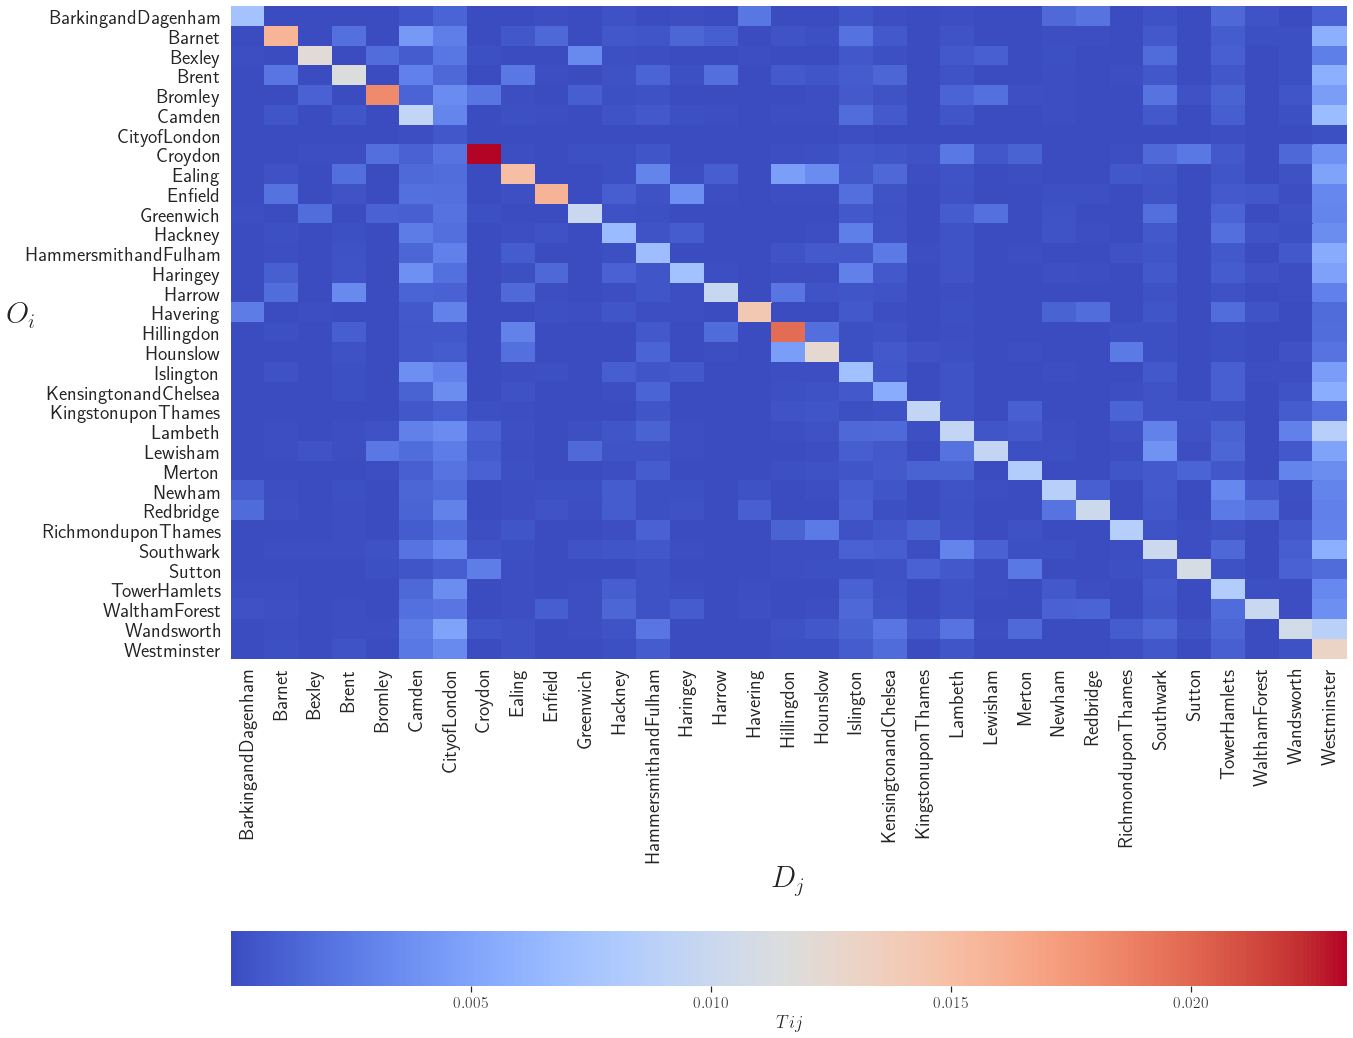

In [16]:
# Change font scaling
sns.set(font_scale=1.5)
# Set plot size
plt.figure(figsize=(20,20))
# Add heatmap
flow_heatmap = sns.heatmap(t,
                            annot=False,
                            cmap="coolwarm",
                            xticklabels=boroughs,
                            yticklabels=boroughs,
                          cbar_kws={'label': r'$T{ij}$','orientation':'horizontal','pad':0.25})
# Add x,y axes labels
plt.xlabel(r"$D_j$",fontsize=30)
yl = plt.ylabel(r"$O_i$",fontsize=30,rotation=90)
yl.set_rotation(0)
plt.tick_params(labelsize=20)
plt.xticks()


# # Save figure to output
# plt.savefig('../data/output/commuter_borough/actual/figures/commuter_flows.png',
#             dpi=1000, 
#             bbox_inches='tight',
#             transparent=True)

## Naive cost matrix

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5]),
 <a list of 33 Text major ticklabel objects>)

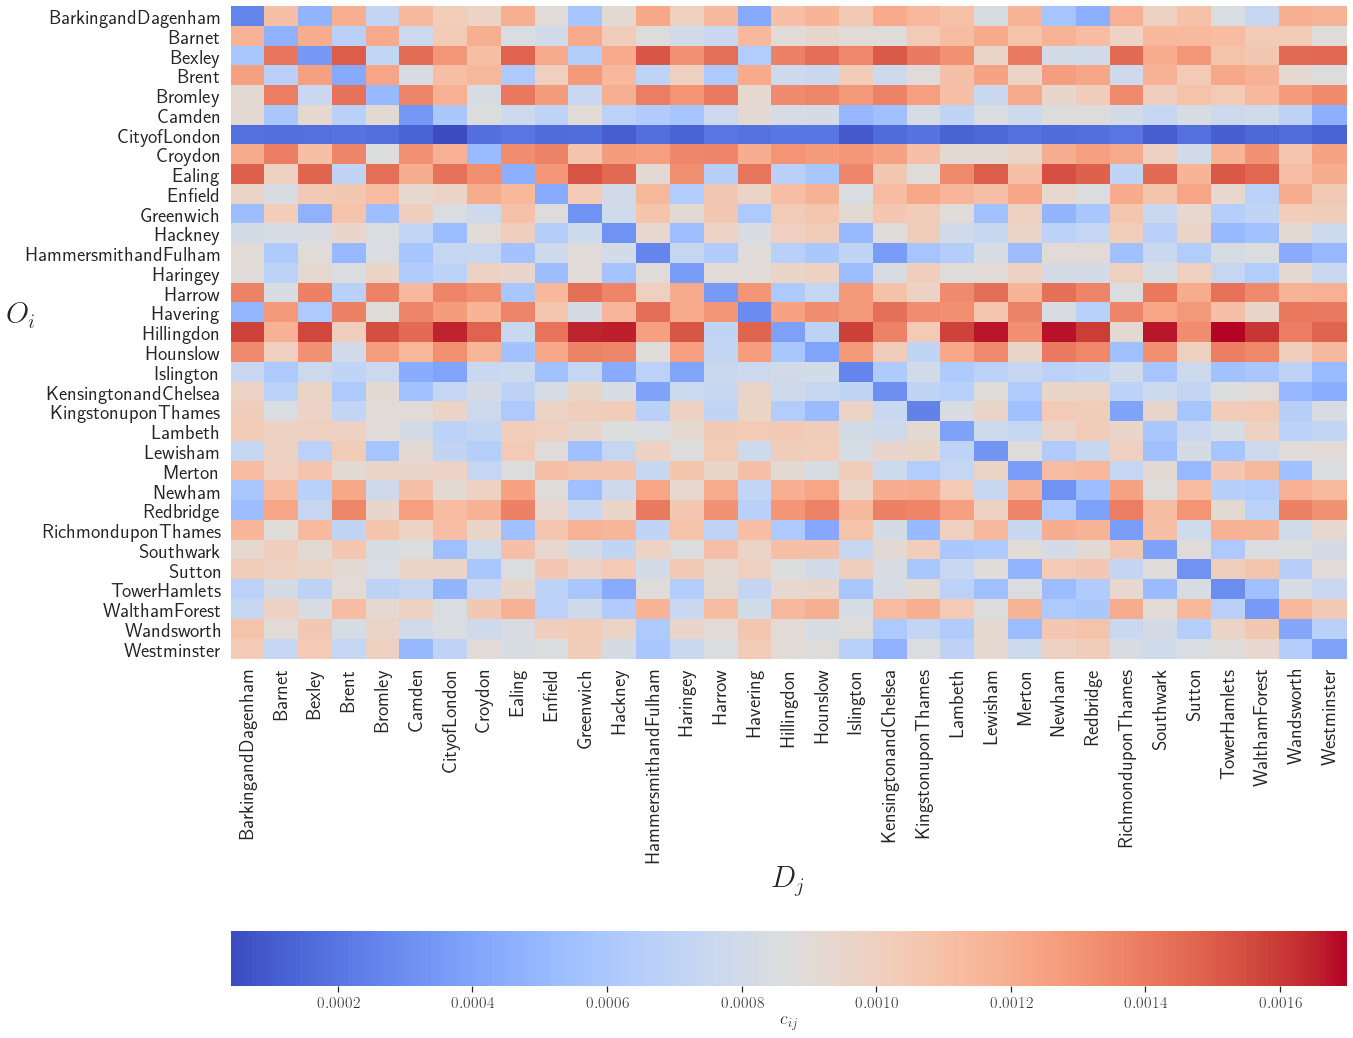

In [18]:
# Change font scaling
sns.set(font_scale=1.5)
# Set plot size
plt.figure(figsize=(20,20))
# Add heatmap
flow_heatmap = sns.heatmap(cnb,
                            annot=False,
                            cmap="coolwarm",
                            xticklabels=boroughs,
                            yticklabels=boroughs,
                          cbar_kws={'label': r'$c_{ij}$','orientation':'horizontal','pad':0.25})
# Add x,y axes labels
plt.xlabel(r"$D_j$",fontsize=30)
yl = plt.ylabel(r"$O_i$",fontsize=30,rotation=90)
yl.set_rotation(0)
plt.tick_params(labelsize=20)
plt.xticks()

## Informative cost matrix 

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5]),
 <a list of 33 Text major ticklabel objects>)

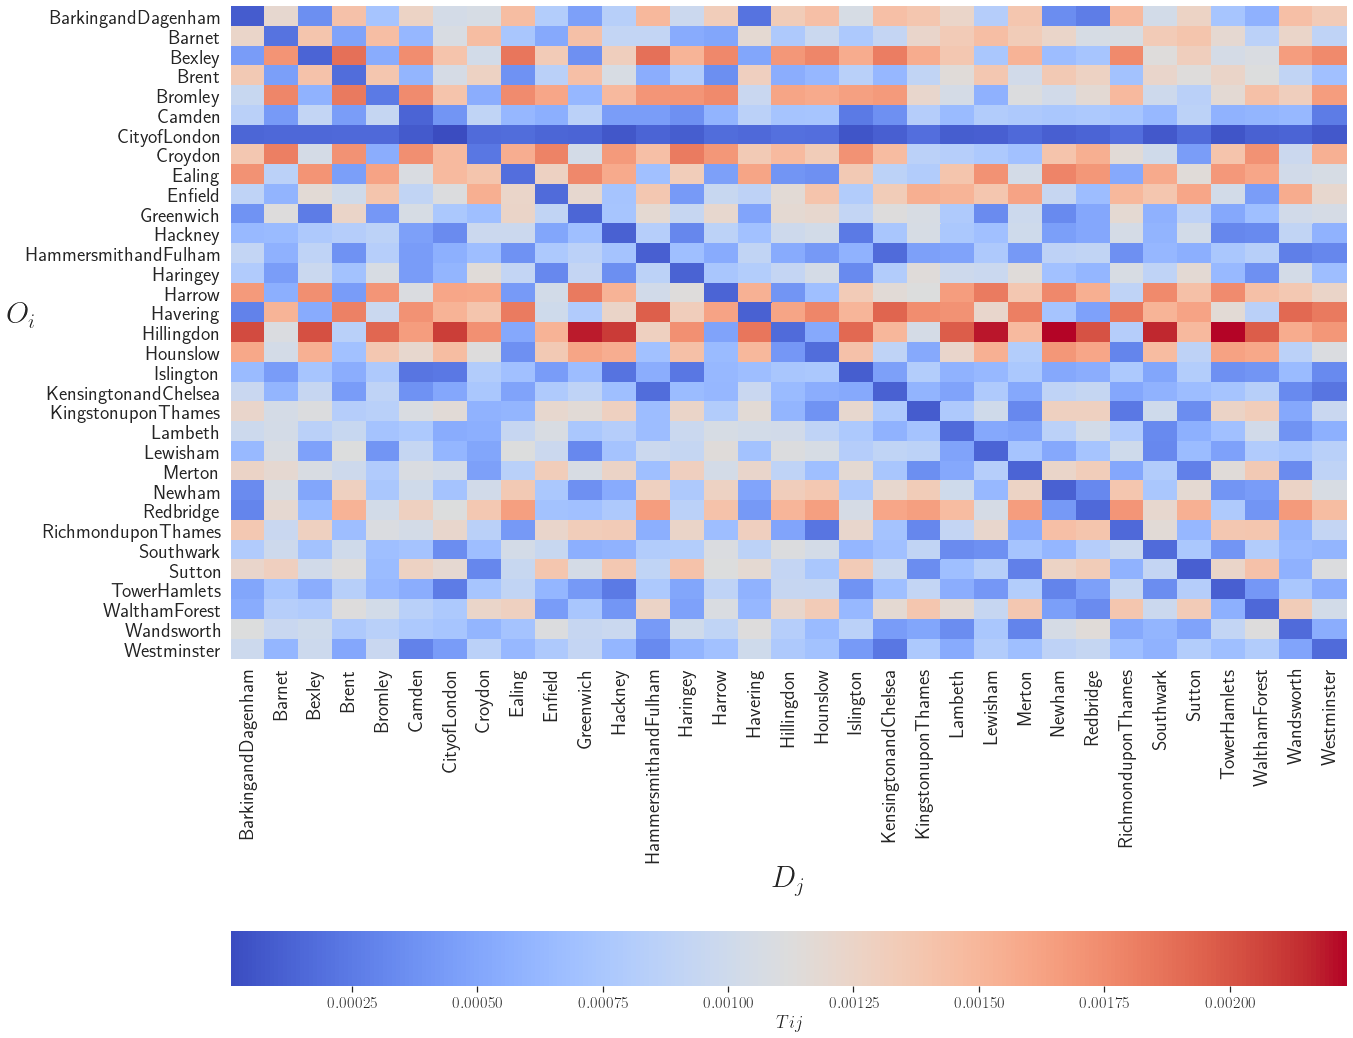

In [19]:
# Change font scaling
sns.set(font_scale=1.5)
# Set plot size
plt.figure(figsize=(20,20))
# Add heatmap
flow_heatmap = sns.heatmap(cib,
                            annot=False,
                            cmap="coolwarm",
                            xticklabels=boroughs,
                            yticklabels=boroughs,
                          cbar_kws={'label': r'$T{ij}$','orientation':'horizontal','pad':0.25})
# Add x,y axes labels
plt.xlabel(r"$D_j$",fontsize=30)
yl = plt.ylabel(r"$O_i$",fontsize=30,rotation=90)
yl.set_rotation(0)
plt.tick_params(labelsize=20)
plt.xticks()

# Necessary functions

In [6]:
def SRMSE(t_hat:np.array,t_actual:np.array):
    """ Computes standardised root mean square error. See equation (22) of
    "A primer for working with the Spatial Interaction modeling (SpInt) module
    in the python spatial analysis library (PySAL)" for more details.

    Parameters
    ----------
    t_hat : np.array [NxM]
        Estimated flows.
    t_actual : np.array [NxM]
        Actual flows.

    Returns
    -------
    float
        Standardised root mean square error of t_hat.

    """
    if t_actual.shape[0] != t_hat.shape[0]:
        raise ValueError(f'Actual flows have {t_actual.shape[0]} rows whereas \hat{T} has {t_hat.shape[0]}.')
    if t_actual.shape[1] != t_hat.shape[1]:
        raise ValueError(f'Actual flows have {t_actual.shape[1]} columns whereas \hat{T} has {t_hat.shape[1]}.')

    n,m = t_actual.shape
    
    return ((np.sum((t_actual - t_hat)**2) / (n*m))**.5) / (np.sum(t_actual) / (n*m))


In [7]:
# def SSI(t_hat:np.array,t_actual:np.array):
#     """ Computes Sorensen similarity index (SSI). See equation (23) of
#     "A primer for working with the Spatial Interaction modeling (SpInt) module
#     in the python spatial analysis library (PySAL)" for more details.

#     Parameters
#     ----------
#     t_hat : np.array [NxM]
#         Estimated flows.
#     t_actual : np.array [NxM]
#         Actual flows.

#     Returns
#     -------
#     float
#         Standardised root mean square error of t_hat.

#     """
#     if t_actual.shape[0] != t_hat.shape[0]:
#         raise ValueError(f'Actual flows have {t_actual.shape[0]} rows whereas \hat{T} has {t_hat.shape[0]}.')
#     if t_actual.shape[1] != t_hat.shape[1]:
#         raise ValueError(f'Actual flows have {t_actual.shape[1]} columns whereas \hat{T} has {t_hat.shape[1]}.')

#     n,m = t_actual.shape
    
#     TThat = np.hstack([t_actual, t_hat])
#     num = 2.0 * np.min(TThat, axis=1)
#     den = t_hat + t_actual
#     return (1.0 / n) * (np.sum(num.reshape((-1, 1)) / den.reshape((-1, 1))))


In [8]:
def reshape_data(f,origin_sup,dest_size,cost_mat):
    od_data = pd.DataFrame(columns=['Origin','Destination','Cost','Flow','OriginSupply','DestinationSize'])
    # Loop over origins and destinations to populate dataframe
    for i,orig in tqdm(enumerate(boroughs),total=len(boroughs)):
        for j,dest in enumerate(boroughs):
            # Add row properties
            new_row = pd.Series({"Origin": orig,
                                 "Destination": dest,
                                 "Cost": cost_mat[i,j],
                                 "Flow": f[i,j],
                                 "OriginSupply": origin_sup[i],
                                 "DestinationSize":dest_size[j]})
            # Append row to dataframe
            od_data = od_data.append(new_row, ignore_index=True)

    # Get flatten data and et column types appropriately
    orig_supply_flat = od_data.OriginSupply.values.astype('float64')
    dest_size_flat = od_data.DestinationSize.values.astype('float64')
    cost_flat = od_data.Cost.values.astype('float64')
    flow = od_data.Flow.values.astype('float64')
    
    return flow,orig_supply_flat,dest_size_flat,cost_flat


In [9]:
def gravity_model(orig,dest_size,cost_mat,a,b):
    flows = np.zeros((M,M))
    
    for i in range(M):
        for j in range(M):
            denum = 0
            for k in range(M):
                denum += (dest_size[k]**a)*np.exp(-b*cost_mat[i,k])
                
            flows[i,j] = orig[i]*(dest_size[j]**a)*np.exp(-b*cost_mat[i,j])/denum

    return flows

# Poisson regression

## Naive cost matrix

In [10]:
# Reshape data
flows_flat,origing_supply_flat,destination_size_flat,cost_matrix_naive_flat = reshape_data(t,ob,kappa*wd,cnb)
flows_flat = (0.7e6*flows_flat).astype('int')
cost_matrix_naive_flat = (0.7e6*cost_matrix_naive_flat)
destination_size_flat = (0.7e6*destination_size_flat)
origing_supply_flat = (0.7e6*origing_supply_flat)

# Train regression model using PySAL
model_naive = pysal.model.spint.Production(flows_flat,origing_supply_flat,destination_size_flat,cost_matrix_naive_flat, 'exp')

# Reconstruct inferred flow matrix from model vector
pysal_flows_naive = model_naive.yhat.reshape((M,M))
pysal_flows_naive_normalised = pysal_flows_naive/np.sum(pysal_flows_naive)

# Print optimised parameters
print('Optimised parameters---------------------')
print('Distance coefficient = ',-model_naive.params[-2:][1])
print('Production coefficient = ',model_naive.params[-2:][0])
print('y-intercept (constant) = ',model_naive.params[0])

100%|██████████| 33/33 [00:04<00:00,  7.00it/s]

Optimised parameters---------------------
Distance coefficient =  0.007654806730313268
Production coefficient =  1.3914583504484792
y-intercept (constant) =  -10.380219883947248


In [11]:
SRMSE(pysal_flows_naive_normalised,t)

1.0033691952685477

## Informative cost matrix

In [53]:
# Reshape data
flows_flat,origing_supply_flat,destination_size_flat,cost_matrix_informative_flat = reshape_data(t,ob,kappa*wd,cib)
flows_flat = (0.7e6*flows_flat).astype('int')
cost_matrix_informative_flat = (0.7e6*cost_matrix_informative_flat)
destination_size_flat = (0.7e6*destination_size_flat)
origing_supply_flat = (0.7e6*origing_supply_flat)

# Train regression model using PySAL
model_informative = pysal.model.spint.Production(flows_flat,origing_supply_flat,destination_size_flat,cost_matrix_informative_flat, 'exp')
# 
# Reconstruct inferred flow matrix from model vector
pysal_flows_informative = model_informative.yhat.reshape((M,M))
pysal_flows_informative_normalised = pysal_flows_informative/np.sum(pysal_flows_informative)

# Print optimised parameters
print('Optimised parameters---------------------')
print('Distance coefficient = ',-model_informative.params[-2:][1])
print('Production coefficient = ',model_informative.params[-2:][0])
print('y-intercept (constant) = ',model_informative.params[0])

100%|██████████| 33/33 [00:05<00:00,  6.39it/s]


Optimised parameters---------------------
Distance coefficient =  0.005289799126911125
Production coefficient =  1.4210781636236058
y-intercept (constant) =  -11.06292798445834


In [54]:
SRMSE(pysal_flows_informative_normalised,t)

1.1279180381426877

# Iterative proportional fitting

## Naive cost matrix

In [91]:
alpha_naive_deter = 1.144
beta_naive_deter =  0.08 #56000
theta_naive_deter = copy.deepcopy(theta)
theta_naive_deter[0] = alpha_naive_deter
theta_naive_deter[1] = beta_naive_deter

alpha_naive_low = 1.14
beta_naive_low = 0.02 # 14000
theta_naive_low = copy.deepcopy(theta)
theta_naive_low[0] = alpha_naive_low
theta_naive_low[1] = beta_naive_low

alpha_naive_high = 0.24
beta_naive_high = 0.08 # 56000
theta_naive_high = copy.deepcopy(theta)
theta_naive_high[0] = alpha_naive_high
theta_naive_high[1] = beta_naive_high

alpha_naive_low_mcmc = 1.1438419582811576
beta_naive_low_mcmc = 0.025494858038379416
theta_naive_low_mcmc = copy.deepcopy(theta)
theta_naive_low_mcmc[0] = alpha_naive_low_mcmc
theta_naive_low_mcmc[1] = beta_naive_low_mcmc

alpha_naive_high_mcmc = 0.2551254382399649
beta_naive_high_mcmc = 0.2070918948256356
theta_naive_high_mcmc = copy.deepcopy(theta)
theta_naive_high_mcmc[0] = alpha_naive_high_mcmc
theta_naive_high_mcmc[1] = beta_naive_high_mcmc


wd_naive_deter = np.array([2.070657938223044794e-02,1.941663250645758385e-02,1.810140500929941984e-02,2.521058156030310526e-02,1.626080991797734798e-02,3.494619700573880355e-02,4.999195533992521062e-02,1.854111967824047594e-02,2.424135027002001508e-02,1.777152634923648625e-02,2.553510602215653541e-02,4.016761437306852478e-02,3.525214483053677739e-02,2.779973946924231554e-02,1.834847871746650774e-02,1.479482413302631721e-02,1.535598222155064828e-02,1.969619618336833008e-02,4.037243921926897405e-02,4.093306025829015343e-02,1.711017893553004252e-02,4.089776747509573512e-02,3.058195090502587032e-02,2.396412319644581831e-02,3.180997657718225707e-02,2.060581708129214165e-02,2.006180604879394258e-02,4.468857501568658519e-02,1.854262541395492944e-02,4.295364129704760947e-02,2.445774607523722860e-02,3.247355583786678407e-02,1.284085607260266881e-01])

wd_naive_low = np.array(np.exp([-3.7976838034828466,-3.588187314812076,-3.830683584062894,-3.55173738796326,-3.7788919370335545,-3.231066761708704,-3.130028156811773,-3.642059500019222,-3.6835456998088683,-3.6368470547451306,-3.6039797666333575,-3.2635267458621824,-3.3420770373682913,-3.3731044844516225,-3.7886255778106372,-3.9885613873290726,-3.955568471933376,-3.791106861856594,-3.189420955419061,-3.2390367098565283,-3.7384171643614166,-3.220803194343605,-3.425681273995523,-3.4932961703261594,-3.5220951352169596,-3.7098104386331103,-3.6943402510905425,-3.210281858647586,-3.6369057176315795,-3.282698602403305,-3.5234103821358165,-3.3247798078238406,-3.1649034548189667]))

wd_naive_high = np.array(np.exp([-3.617331195305436,-3.568179255404358,-3.6833571316083638,-3.4774083656582873,-3.7197791950973875,-3.3512669531003008,-3.3181580328159175,-3.604774709481396,-3.527196640174058,-3.6209364032548805,-3.499089400260724,-3.347986458037072,-3.369197017745257,-3.4128318839135035,-3.6544800440239107,-3.854136064811093,-3.8091025118980686,-3.629684999607939,-3.3339236752181285,-3.3349616668382023,-3.679097287563421,-3.3379256665319637,-3.415667654902526,-3.478216569310128,-3.433444854677165,-3.5910886059581526,-3.5958668148150807,-3.3344941684517564,-3.604458239480541,-3.3507815042520863,-3.4817770117686253,-3.3802002548619012,-3.328045296408103]))

wd_naive_low_mcmc = np.array([0.01535272856027297,0.02784310749669245,0.01813951393666429,0.02589748143063775,0.022989104698455876,0.05295615426763433,0.0633396022510792,0.028959347973088315,0.02619317630974522,0.02428131280422454,0.01935207696661053,0.028010516939202333,0.029180776254873815,0.021269257152965928,0.01894355089513908,0.018133484239765515,0.02580564173109832,0.026053085722321324,0.03799383527180015,0.034144187563788564,0.019615413206541765,0.03157399268632203,0.021266076639509985,0.021576473960582286,0.02124266050324558,0.020069374332016814,0.020485213018767382,0.0410665602464456,0.01980689346004095,0.03647749020390299,0.019531623721674034,0.029518469742615832,0.12393617701875043])


wd_naive_high_mcmc = np.array([0.01208559, 0.0301875, 0.01664935, 0.02561508, 0.02500212, 0.06231693,
 0.07120561, 0.03397005, 0.0294578,  0.024394,   0.01585433, 0.02400428,
 0.02719989, 0.01675203, 0.01773296, 0.01941132, 0.03980872, 0.03270464,
 0.03679499, 0.03277849, 0.01812414, 0.02874812, 0.01676873, 0.01804732,
 0.01765307, 0.01820284, 0.01881533, 0.04143669, 0.01709295, 0.03653884,
 0.01540842, 0.02740623, 0.12066511])

In [92]:
# Construct flow matrix
dsi = DSIM('synthetic',cm)


In [93]:
T_naive_deter = gravity_model(ob,wd_naive_deter,cnb,theta_naive_deter[0],theta_naive_deter[1])

# T_naive_deter = np.zeros((M,M))

# value = dsi.infer_flows_ipf_procedure(T_naive_deter,
#                                 ob,
#                                 wd_naive_deter*kappa,  
#                                 cnb,
#                                 wd_naive_deter,
#                                 np.ones(M),
#                                 np.ones(M),
#                                 M,
#                                 M,
#                                 theta_naive_deter,
#                                 870,
#                                 0.000000001,
#                                 False)

In [94]:
SRMSE(T_naive_deter,t)

2.235621835438942

In [95]:
T_naive_low =  gravity_model(ob,wd_naive_low,cnb,theta_naive_low[0],theta_naive_low[1])


# T_naive_low = np.zeros((M,M))

# # Construct flow matrix
# dsi = DSIM('synthetic',cm)

# value = dsi.infer_flows_ipf_procedure_singly(T_naive_low,
#                                 ob,
#                                 cnb,
#                                 wd,
#                                 np.ones(M),
#                                 np.ones(M),
#                                 M,
#                                 M,
#                                 theta_naive_low,
#                                 84,
#                                 0.000000001,
#                                 False)
# value = dsi.infer_flows_ipf_procedure(T_naive_low,
#                                 ob,
#                                 wd*kappa,  
#                                 cnb,
#                                 wd,
#                                 np.ones(M),
#                                 np.ones(M),
#                                 M,
#                                 M,
#                                 theta_naive_low,
#                                 910,
#                                 0.000000001,
#                                 False)

In [96]:
SRMSE(T_naive_low,t)

2.297338924555266

In [97]:
T_naive_high =  gravity_model(ob,wd_naive_high,cnb,theta_naive_high[0],theta_naive_high[1])

T_naive_high = np.zeros((M,M))

# Construct flow matrix
si = DSIM('synthetic',cm)

# value = si.infer_flows_ipf_procedure_singly(T_naive_high,
#                                 ob,
#                                 wd,
#                                 cnb,
#                                 np.ones(M),
#                                 np.ones(M),
#                                 M,
#                                 M,
#                                 theta_naive_high,
#                                 10000,
#                                 0.000000001,
#                                 False)
# value = dsi.infer_flows_ipf_procedure(T_naive_high,
#                                 ob,
#                                 wd*kappa,  
#                                 cnb,
#                                 wd,
#                                 np.ones(M),
#                                 np.ones(M),
#                                 M,
#                                 M,
#                                 theta_naive_high,
#                                 890,
#                                 0.000000001,
#                                 False)

In [98]:
SRMSE(T_naive_high,t)

2.5520006733501233

In [99]:
T_naive_low_mcmc =  gravity_model(ob,wd_naive_low_mcmc,cnb,theta_naive_low_mcmc[0],theta_naive_low_mcmc[1])


In [100]:
SRMSE(T_naive_low_mcmc,t)

2.2036847450247548

In [101]:
T_naive_high_mcmc =  gravity_model(ob,wd_naive_high_mcmc,cnb,theta_naive_high_mcmc[0],theta_naive_high_mcmc[1])

# T_naive_high_mcmc = np.zeros((M,M))

# # Construct flow matrix
# si = DSIM('synthetic',cm)

# # value = si.infer_flows_ipf_procedure_singly(T_naive_high,
# #                                 ob,
# #                                 wd,
# #                                 cnb,
# #                                 np.ones(M),
# #                                 np.ones(M),
# #                                 M,
# #                                 M,
# #                                 theta_naive_high,
# #                                 10000,
# #                                 0.000000001,
# #                                 False)
# value = dsi.infer_flows_ipf_procedure(T_naive_high_mcmc,
#                                 ob,
#                                 wd_naive_high_mcmc*kappa,  
#                                 cnb,
#                                 wd_naive_high_mcmc,
#                                 np.ones(M),
#                                 np.ones(M),
#                                 M,
#                                 M,
#                                 theta_naive_high_mcmc,
#                                 1100,
#                                 0.000000001,
#                                 False)

In [102]:
SRMSE(T_naive_high_mcmc,t)

2.291612441469509

## Informative cost matrix

In [106]:
alpha_informative_deter = 1.122
beta_informative_deter = 0.068 # 47600
theta_informative_deter = copy.deepcopy(theta)
theta_informative_deter[0] = alpha_informative_deter
theta_informative_deter[1] = beta_informative_deter

alpha_informative_low = 1.12
beta_informative_low = 0.02 # 14000
theta_informative_low = copy.deepcopy(theta)
theta_informative_low[0] = alpha_informative_low
theta_informative_low[1] = beta_informative_low

alpha_informative_high = 0.24
beta_informative_high = 0.06 # 42000
theta_informative_high = copy.deepcopy(theta)
theta_informative_high[0] = alpha_informative_high
theta_informative_high[1] = beta_informative_high

alpha_informative_low_mcmc = 1.1351370418374023
beta_informative_low_mcmc = 0.016174626315154338
theta_informative_low_mcmc = copy.deepcopy(theta)
theta_informative_low_mcmc[0] = alpha_informative_low_mcmc
theta_informative_low_mcmc[1] = beta_informative_low_mcmc

alpha_informative_high_mcmc = 0.23338040309955535
beta_informative_high_mcmc = 0.12498763274450253
theta_informative_high_mcmc = copy.deepcopy(theta)
theta_informative_high_mcmc[0] = alpha_informative_high_mcmc
theta_informative_high_mcmc[1] = beta_informative_high_mcmc


wd_informative_deter = np.array([2.147423075773007700e-02,1.796046849801963274e-02,1.774929503910763900e-02,2.561911329750712202e-02,1.543300167855256311e-02,3.528996906100205500e-02,5.568227914098574510e-02,1.712372025808790027e-02,2.578155605985285939e-02,1.568789990112197039e-02,2.604503702992880254e-02,3.710662915929443390e-02,3.612930246041822641e-02,2.586574512085297942e-02,1.762763353271277686e-02,1.527132497977787100e-02,1.567397761389176941e-02,1.972014833371949286e-02,3.938159838927355466e-02,4.324373919081616474e-02,1.579387164790374207e-02,3.930114829389225878e-02,3.023764606475232500e-02,2.329187087266072070e-02,3.367300451952296575e-02,2.019368612487509179e-02,1.973541256004710670e-02,4.746801619389405535e-02,1.739806108263606405e-02,4.443980668850953941e-02,2.345006921200609717e-02,3.335167275828267164e-02,1.278073090724854144e-01])

wd_informative_low = np.exp([-3.889684532289478,-3.7396195238101555,-3.9324822677819977,-3.588692496825615,-3.969441058157571,-3.1512035805899887,-2.854127191577439,-3.870709400435917,-3.727729617359939,-3.8580757080082266,-3.6386105211478568,-3.2219017977275763,-3.2583722393587458,-3.459463035535039,-3.929271404020793,-4.12805082933884,-4.091485907871028,-3.867777313119736,-3.1014905928849745,-3.0838833690889196,-3.9038819196391255,-3.1954764535623466,-3.455536237292328,-3.6090868885376435,-3.510712623381824,-3.812221318799587,-3.781058342541209,-3.082357005417378,-3.8485844381425247,-3.1612319713212265,-3.61290346485154,-3.3098308290113305,-2.891665081448425])

wd_informative_high = np.exp([-3.6187851068259986,-3.6028322902739047,-3.7002401888260485,-3.4597346177884467,-3.7780589622553844,-3.3264067723492454,-3.279181297736718,-3.6834330026205833,-3.5059142529869405,-3.707712730217493,-3.484544241345718,-3.3349992955278593,-3.342754291472875,-3.4230861853526546,-3.688566855582926,-3.868519381154879,-3.8234272797198114,-3.630820765091671,-3.3119788480518975,-3.3046741972937492,-3.737040153656239,-3.3287703006680123,-3.408597585554112,-3.4946532633758833,-3.408980179362374,-3.601446352985902,-3.5985822862867662,-3.305340671943329,-3.668621558624226,-3.3190503664712288,-3.4886967102984556,-3.3629989015265886,-3.2800854968533537])

wd_informative_low_mcmc = np.array([0.015315177874046657,0.026811078616787484,0.018100735160597136,0.025910926575239347,0.022023650832786682,0.05247836756669653,0.06436932731116252,0.026847670341084748,0.026368354571125192,0.022884425405743446,0.019480249229825948,0.02806444321568518,0.029642394031535214,0.021111946485483014,0.01861236415710276,0.017967187611224796,0.02535576854599674,0.026116674133174644,0.037910368600128135,0.034619357244857325,0.019112492663510883,0.031347702691827684,0.02123467406981674,0.021120019561934815,0.021495623231976704,0.019884488374428733,0.020392146457664434,0.04085603720825694,0.01895511389768031,0.03678065507685092,0.019269611161279305,0.029531143893954215,0.13327484718196927])

wd_informative_high_mcmc = np.array([0.01208559, 0.0301875,  0.01664935, 0.02561508, 0.02500212, 0.06231693,
 0.07120561, 0.03397005, 0.0294578,  0.024394,   0.01585433, 0.02400428,
 0.02719989, 0.01675203, 0.01773296, 0.01941132, 0.03980872, 0.03270464,
 0.03679499, 0.03277849, 0.01812414, 0.02874812, 0.01676873, 0.01804732,
 0.01765307, 0.01820284, 0.01881533, 0.04143669, 0.01709295, 0.03653884,
 0.01540842, 0.02740623, 0.12066511])

In [107]:
T_informative_deter = gravity_model(ob,wd_informative_deter,cnb,theta_informative_deter[0],theta_informative_deter[1])

# np.zeros((M,M))

# # Construct flow matrix
# dsi = DSIM('synthetic',cm)

# value = dsi.infer_flows_ipf_procedure(T_informative_deter,
#                                 ob,
#                                 wd_informative_deter*kappa,  
#                                 cnb,
#                                 wd_informative_deter,
#                                 np.ones(M),
#                                 np.ones(M),
#                                 M,
#                                 M,
#                                 theta_informative_deter,
#                                 880,
#                                 0.000000001,
#                                 False)

In [108]:
SRMSE(T_informative_deter,t)

2.2332169552144836

In [109]:
T_informative_low = gravity_model(ob,wd_informative_low,cnb,theta_informative_low[0],theta_informative_low[1])

# np.zeros((M,M))

# # Construct flow matrix
# dsi = DSIM('synthetic',cm)

# value = dsi.infer_flows_ipf_procedure(T_informative_low,
#                                 ob,
#                                 wd*kappa,  
#                                 cnb,
#                                 wd,
#                                 np.ones(M),
#                                 np.ones(M),
#                                 M,
#                                 M,
#                                 theta_informative_low,
#                                 930,
#                                 0.000000001,
#                                 False)

In [112]:
SRMSE(T_informative_low,t)

2.276061396095525

In [113]:
T_informative_high = gravity_model(ob,wd_informative_high,cnb,theta_informative_high[0],theta_informative_high[1])

# np.zeros((M,M))

# # Construct flow matrix
# dsi = DSIM('synthetic',cm)

# value = dsi.infer_flows_ipf_procedure(T_informative_high,
#                                 ob,
#                                 wd*kappa,  
#                                 cnb,
#                                 wd,
#                                 np.ones(M),
#                                 np.ones(M),
#                                 M,
#                                 M,
#                                 theta_informative_high,
#                                 900,
#                                 0.000000001,
#                                 False)

In [114]:
SRMSE(T_informative_high,t)

2.326116899209334

In [117]:
T_informative_low_mcmc = gravity_model(ob,wd_informative_low_mcmc,cnb,theta_informative_low_mcmc[0],theta_informative_low_mcmc[1])


In [118]:
SRMSE(T_informative_low_mcmc,t)

2.207911178303344

In [115]:
T_informative_high_mcmc = gravity_model(ob,wd_informative_high_mcmc,cnb,theta_informative_high_mcmc[0],theta_informative_high_mcmc[1])

# np.zeros((M,M))

# # Construct flow matrix
# dsi = DSIM('synthetic',cm)

# value = dsi.infer_flows_ipf_procedure(T_informative_high_mcmc,
#                                 ob,
#                                 wd_informative_high_mcmc*kappa,  
#                                 cnb,
#                                 wd_informative_high_mcmc,
#                                 np.ones(M),
#                                 np.ones(M),
#                                 M,
#                                 M,
#                                 theta_informative_high_mcmc,
#                                 1100,
#                                 0.000000001,
#                                 False)

In [116]:
SRMSE(T_informative_high_mcmc,t)

2.295079509344672

## Compare cost matrices

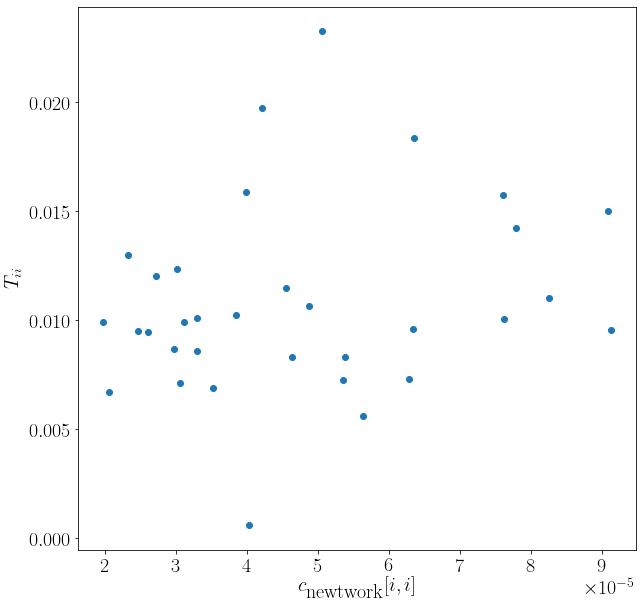

In [14]:
plt.figure(figsize=(10,10))
plt.xlabel(r'$c_{\textrm{newtwork}}[i,i]$')
plt.ylabel(r'$T_{ii}$')
plt.scatter(x=np.diagonal(ci),y=np.diagonal(t))
# plt.plot(np.linspace(0,8e-5,1000),np.linspace(0,8e-5,1000))

# plt.savefig(f"../data/output/commuter_ward/actual/figures/cost_matrices_diagonals.png",
#             dpi=1000, 
#             bbox_inches='tight',transparent=True)

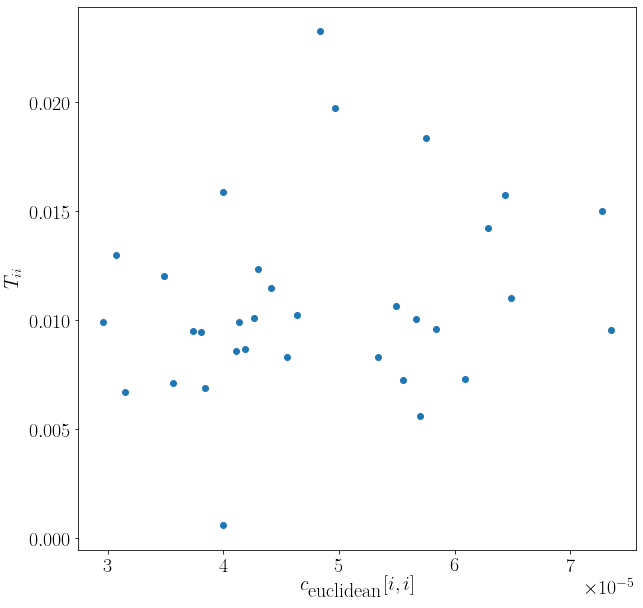

In [15]:
plt.figure(figsize=(10,10))
plt.xlabel(r'$c_{\textrm{euclidean}}[i,i]$')
plt.ylabel(r'$T_{ii}$')
plt.scatter(x=np.diagonal(cn),y=np.diagonal(t))
# plt.plot(np.linspace(0,8e-5,1000),np.linspace(0,8e-5,1000))

# plt.savefig(f"../data/output/commuter_ward/actual/figures/cost_matrices_diagonals.png",
#             dpi=1000, 
#             bbox_inches='tight',transparent=True)

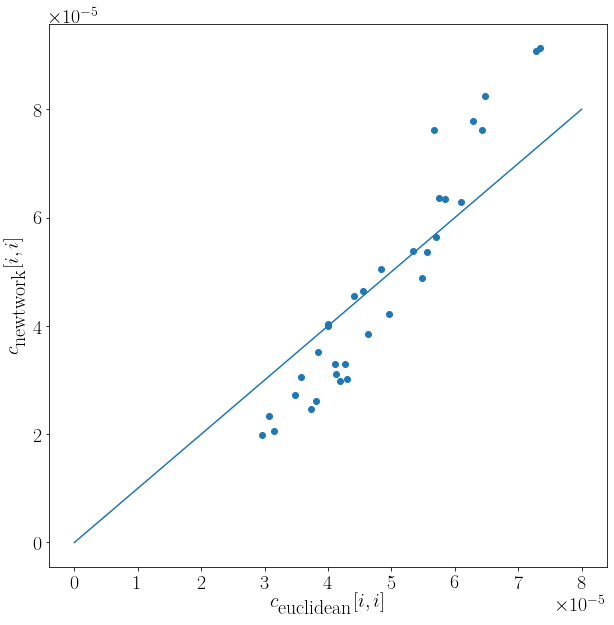

In [37]:
plt.figure(figsize=(10,10))
plt.xlabel(r'$c_{\textrm{euclidean}}[i,i]$')
plt.ylabel(r'$c_{\textrm{newtwork}}[i,i]$')
plt.scatter(x=np.diagonal(cn),y=np.diagonal(ci))
plt.plot(np.linspace(0,8e-5,1000),np.linspace(0,8e-5,1000))

plt.savefig(f"../data/output/commuter_ward/actual/figures/cost_matrices_diagonals.png",
            dpi=1000, 
            bbox_inches='tight',transparent=True)

In [38]:
SRMSE(cib,t)

2.5763575707860964

In [39]:
SRMSE(cnb,t)

2.487622881193811